<h1>Installing RDKit</h1>

In [1]:
import rdkit
import deepchem as dc
import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn
from deepchem.metrics import to_one_hot
from deepchem.feat.mol_graphs import ConvMol
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
k = 4
max_epoch = 100
# optimizer = tf.keras.optimizers.Adam(0.15)
# PGNN: Tanh, Tanh, Tanh, Tanh

In [2]:
dc.__version__

'2.5.0'

In [3]:
np.__version__

'1.19.5'

In [4]:
tf.__version__

'2.6.0'

In [5]:
df = pd.read_csv('https://raw.githubusercontent.com/saharctech/Binding-Free-Energy-Prediction-Host-Guest-System/master/Results/dataset.csv')

In [6]:
df.head()

,dataset group name,Dataset Name,Host,Guest,Ex _G_(kcal/mol),Ex _G_SEM,EX _H_(kcal/mol),EX _H_SEM,entropy,pb_guest_Etot,...,gb_host_1-4EEL,gb_host_EELEC,gb_host_EGB,gb_host_ESURF,gb_delta_H,pb_delta_H,EX _delta_H_(kcal/mol),gb_Ex_difference,SQR_gbnsr6_Ex_difference,pb_Ex_difference
0,Mobley benchmarkset,cd-set1,acd,guest-1,-1.575,0.019,-2.17,0.05,-0.595,-47.8832,...,423.5761,-428.9520,-96.4471,5.1691,-1.9950,-0.8408,-2.17,0.1750,0.030625,1.3292
1,Mobley benchmarkset,cd-set1,acd,guest-2,-3.533,0.004,-4.19,0.02,-0.657,-52.0758,...,412.6663,-397.9784,-106.4154,5.0726,-11.2624,-8.4809,-4.19,-7.0724,50.018842,-4.2909
2,Mobley benchmarkset,cd-set1,acd,guest-3,-4.606,0.007,-5.46,0.03,-0.854,-51.5323,...,426.2925,-429.3068,-95.2452,5.1352,-15.4074,-13.8234,-5.46,-9.9474,98.950767,-8.3634
3,Mobley benchmarkset,cd-set1,acd,guest-4,-2.130,0.016,-2.74,0.02,-0.610,2.3898,...,420.0687,-416.5215,-97.4461,5.0849,-10.5586,-11.3319,-2.74,-7.8186,61.130506,-8.5919
4,Mobley benchmarkset,cd-set1,acd,guest-5,-2.510,0.060,-2.99,0.23,-0.480,-3.2280,...,425.7315,-435.9689,-91.2312,5.0881,-14.5517,-14.0485,-2.99,-11.5617,133.672907,-11.0585


<h1>Reading Mobley PDB files</h1>
<p>Here each PDB file will be read and saved in Mol data type defined in RDKit and used by DeepChem</p>

In [7]:
# Dictionary with complex names as keys and molecule as values
PDBs = {}
from os import listdir
from os.path import isfile, join
mypath = '/Users/misspotato/Documents/Github/Binding-Free-Energy-Prediction-Host-Guest-System/PDB_bkp/host-guest'
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
for f in onlyfiles:
    PDBs.update({f.split('.')[0]: rdkit.Chem.rdmolfiles.MolFromPDBFile(mypath + '/' + f)})
    

In [8]:
# Randomly shuffling the PDBs
import random
l = list(PDBs.items())
random.shuffle(l)
PDBs = dict(l)

In [9]:
len(PDBs)

73

<h1>Featurizing</h1>
<p>GraphConv model needs ConvMolFeaturizer</p>

<h4>K-fold cross validation </h4>
We have 72 dataponts. We choose k=4 which makes 4 groups of 18 datapoints each.
K=4 results 0.25% of the dataset.

In [10]:
featurizer = dc.feat.ConvMolFeaturizer(per_atom_fragmentation=False)

In [11]:
TRAIN_SET_PERCENTAGE = 1-(1/k)
VAL_SET_PERCENTAGE = 1/k

In [12]:
PDBs.pop('',None)
X = []
X_ids = []
for i in PDBs.keys():
    X_ids.append(i)
    X.append(featurizer.featurize(PDBs[i]))
TEST_SIZE = int(len(X) * VAL_SET_PERCENTAGE)

In [13]:
TEST_SIZE

18

In [14]:
len(X)

72

In [15]:
host_names =[]
guest_names = []
host_names = [i.split('-')[0] for i in X_ids]
guest_names = ['guest-' + (i.split('-')[1].replace('s', '')) for i in X_ids]

<h1> PGNN model class </h1>

In [16]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers


class PGNN(tf.keras.Model):

  def modify_graphgather(self, batch_size):
    self.readout.batch_size = batch_size
    self.batch_size = batch_size
  def __init__(self, batch_size):
    super(PGNN, self).__init__()
    self.input_shapes = None
    self.batch_size = batch_size
    self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm1 = layers.BatchNormalization()
    self.gp1 = GraphPool()

    self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
    self.batch_norm2 = layers.BatchNormalization()
    self.gp2 = GraphPool()

    self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
    self.batch_norm3 = layers.BatchNormalization()
    self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)

    self.dense2 = layers.Dense(1)
    self.dense3 = layers.Dense(1, 
         kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
         bias_initializer=initializers.Zeros())

  def call(self, inputs):
    inputs = inputs[0]
    x = []
#     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
#                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
    for i in range(len(self.input_shapes)):
        x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
    for i in range(1, len(self.input_shapes)):
        x[i] = tf.cast(x[i], tf.int32)
    x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 15])
    gc1_output = self.gc1(x)
    batch_norm1_output = self.batch_norm1(gc1_output)
    gp1_output = self.gp1([batch_norm1_output] + x[1:])

    gc2_output = self.gc2([gp1_output] + x[1:])
    batch_norm2_output = self.batch_norm1(gc2_output)
    gp2_output = self.gp2([batch_norm2_output] + x[1:])

    dense1_output = self.dense1(gp2_output)
    batch_norm3_output = self.batch_norm3(dense1_output)
    readout_output = self.readout([batch_norm3_output] + x[1:])
    
    model_var = self.dense2(readout_output)
    binding_affinity = tf.concat([model_var, x_add], axis=1)
    return self.dense3(binding_affinity)

<h1> Data driven class </h1>

In [17]:
from deepchem.models.layers import GraphConv, GraphPool, GraphGather
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Input, BatchNormalization, Concatenate
from tensorflow.keras import initializers

# batch_size = int(len(df) / 2)

class GBGraphConvModel(tf.keras.Model):
   
    def modify_graphgather(self, batch_size):
        self.readout.batch_size = batch_size
        self.batch_size = batch_size

    def __init__(self, batch_size):
        super(GBGraphConvModel, self).__init__()
        self.input_shapes = None
        self.batch_size = batch_size
        self.gc1 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm1 = layers.BatchNormalization()
        self.gp1 = GraphPool()

        self.gc2 = GraphConv(32, activation_fn=tf.nn.tanh)
        self.batch_norm2 = layers.BatchNormalization()
        self.gp2 = GraphPool()

        self.dense1 = layers.Dense(64, activation=tf.nn.tanh)
        self.batch_norm3 = layers.BatchNormalization()
        self.readout = GraphGather(batch_size=self.batch_size, activation_fn=tf.nn.tanh)
        self.dense2 = layers.Dense(1, bias_initializer=initializers.Zeros())
    #     self.dense3 = layers.Dense(1, 
    #          kernel_initializer=initializers.Constant([.5, -1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1]),
    #          bias_initializer=initializers.Zeros())

    def call(self, inputs):
        inputs = inputs[0]
        x = []
    #     input_shapes = [[4822, 75], [11, 2], [4822], [1142, 1], [1635, 2], [2042, 3],
    #                    [3, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10]]
        for i in range(len(self.input_shapes)):
            x.append(tf.reshape(inputs[i][inputs[i] != 1.123456], self.input_shapes[i]))
        for i in range(1, len(self.input_shapes)):
            x[i] = tf.cast(x[i], tf.int32)
        x_add = tf.reshape(inputs[13][inputs[13] != 1.123456], [self.batch_size, 15])
        gc1_output = self.gc1(x)
        batch_norm1_output = self.batch_norm1(gc1_output)
        gp1_output = self.gp1([batch_norm1_output] + x[1:])

        gc2_output = self.gc2([gp1_output] + x[1:])
        batch_norm2_output = self.batch_norm1(gc2_output)
        gp2_output = self.gp2([batch_norm2_output] + x[1:])

        dense1_output = self.dense1(gp2_output)
        batch_norm3_output = self.batch_norm3(dense1_output)
        readout_output = self.readout([batch_norm3_output] + x[1:])

        model_var = self.dense2(readout_output)
    #     binding_affinity = tf.concat([model_var, x_add], axis=1)
        return model_var #self.dense3(binding_affinity)


In [49]:
k=4

<h1> K-fold cross validation </h1>

<h5> pgnn_train_losses: stores the training losses of PGNN model</h5>
<h5> pgnn_val_losses: stores the validation losses of PGNN model </h5>
<h5> pgnn_rmse_test: stores the PGNN test rmse</h5>
<h5> pgnn_rmse_train: stores the PGNN train rmse</h5>
<h5> k_fold is the number of folds for cross validation</h5>

In [50]:
k_fold = k

# PGNN model variables
pgnn_train_losses = [[] for _ in range(k_fold)]
pgnn_val_losses = [[] for _ in range(k_fold)]
pgnn_rmse_train, pgnn_rmse_test = [], []

# Data Driven model variables
dd_train_losses = [[] for _ in range(k_fold)]
dd_val_losses = [[] for _ in range(k_fold)]
dd_rmse_train, dd_rmse_test, rmse_gbnsr6_ex, rmse_gb_pb = [], [], [], []

# Physics-based model variables
physics_based_rmse_train, physics_based_rmse_test, rmse_pbsa_ex , rmse_gbnsr6_ex = [], [], [], []
gb_r_squared, pb_r_squared, pbgb_r_squared = [], [], []

for fold in range(k_fold):
    # fold=0 -> 0 * (0.25 * 72) = 0
    # fold=1 -> 1 * (0.25 * 72) = 18
    # fold=2 -> 2 * (0.25 * 72) = 36
    # fold=3 -> 3 * (0.25 *72) = 54
    X, X_ids, host_names_val,guest_names_val, host_names_test, guest_names_test = [], [], [], [], [], []
    host_names_train, guest_names_train, X_val_featurized, X_test_featurized, X_train_featurized  = [], [], [], [], []
    
    
    for k in PDBs.keys():
        X_ids.append(k)
        X.append(featurizer.featurize(PDBs[k]))
    val_split_index_begin = int(fold * TEST_SIZE)
#     print(f"begin {val_split_index_begin}")
    val_split_index_end = int(val_split_index_begin) + int(TEST_SIZE)
#     print(f"end {val_split_index_end}")
    # validation
    host_names_val = host_names[val_split_index_begin:val_split_index_end]
    guest_names_val = guest_names[val_split_index_begin:val_split_index_end]
    # Test set
    host_names_test = host_names[val_split_index_begin:val_split_index_end]
    guest_names_test = guest_names[val_split_index_begin:val_split_index_end]
    # Train set
    host_names_train = [host_names[i] for i in range(len(host_names)) if i not in range(val_split_index_begin,val_split_index_end)]
    guest_names_train = [guest_names[i] for i in range(len(guest_names)) if i not in range(val_split_index_begin,val_split_index_end)]

    X = [x[0] for x in X]
    
    X_val_featurized = X[val_split_index_begin : val_split_index_end]
    X_test_featurized = X[val_split_index_begin : val_split_index_end]
#     for i in range(val_split_index_begin,val_split_index_end):
#         X = X.pop(i)
    X_train_featurized = [X[i] for i in range(len(X)) if i not in range(val_split_index_begin, val_split_index_end)]
    
    ### Step
    
    x_add_train, x_add_val, x_add_test, y_train, y_val, y_test = [], [], [], [], [], []
    # Train
    for i in range(len(host_names_train)):
        new_df = df[(df['Host'] == host_names_train[i]) & (df['Guest'] == guest_names_train[i])]
        y_train.append(new_df['EX _H_(kcal/mol)'].to_numpy()[0])
        x_add_train.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                             and ('Ex_difference' not in c) and ('gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
    y_train = np.array(y_train)
    # Val
    for i in range(len(host_names_val)):
        new_df = df[(df['Host'] == host_names_val[i]) & (df['Guest'] == guest_names_val[i])]
        y_val.append(new_df['EX _H_(kcal/mol)'].to_numpy()[0])
        x_add_val.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                             and ('Ex_difference' not in c) and ('gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
    y_val = np.array(y_val)

    # Test
    for i in range(len(host_names_test)):
        new_df = df[(df['Host'] == host_names_test[i]) & (df['Guest'] == guest_names_test[i])]
        y_test.append(new_df['EX _H_(kcal/mol)'].to_numpy()[0])
        x_add_test.append(new_df[[c for c in df.columns if ('Etot' not in c) and ('delta' not in c)
                             and ('Ex_difference' not in c) and ('gb_' in c or 'VDWAALS' in c)]].to_numpy()[0])
    y_test = np.array(y_test)
    
    x_preprocessed_train, x_preprocessed_val, x_preprocessed_test = [], [], []
    
    ## Step
    
    # for X train
    multiConvMol = ConvMol.agglomerate_mols(X_train_featurized)
    x_preprocessed_train = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_train.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_train.append(np.array(x_add_train))

    ## for X val
    multiConvMol = ConvMol.agglomerate_mols(X_val_featurized)
    x_preprocessed_val = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_val.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_val.append(np.array(x_add_val))


    ## for X test
    multiConvMol = ConvMol.agglomerate_mols(X_test_featurized)
    x_preprocessed_test = [multiConvMol.get_atom_features(), multiConvMol.deg_slice, np.array(multiConvMol.membership)]
    for i in range(1, len(multiConvMol.get_deg_adjacency_lists())):
        x_preprocessed_test.append(multiConvMol.get_deg_adjacency_lists()[i])
    x_preprocessed_test.append(np.array(x_add_test))
    
    ### Step
    
    # Train
    x_train = np.full([14, np.max([v.shape[0] for v in x_preprocessed_train]),
                      np.max([v.shape[1] for v in x_preprocessed_train if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_train):
        if len(j.shape) > 1:
            x_train[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_train[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_train = x_train.reshape([1] + list(x_train.shape))

    # Validation
    x_val = np.full([14, np.max([v.shape[0] for v in x_preprocessed_val]),
                      np.max([v.shape[1] for v in x_preprocessed_val if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_val):
        if len(j.shape) > 1:
            x_val[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_val[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_val = x_val.reshape([1] + list(x_val.shape))

    # Test
    x_test = np.full([14, np.max([v.shape[0] for v in x_preprocessed_test]),
                      np.max([v.shape[1] for v in x_preprocessed_test if len(v.shape) > 1])], 1.123456)
    for i,j in enumerate(x_preprocessed_test):
        if len(j.shape) > 1:
            x_test[i][:j.shape[0],:j.shape[1]] = np.array(j)
        else:
            x_test[i][:len(j), :1] = np.array(j).reshape(j.shape[0], 1)
    x_test = x_test.reshape([1] + list(x_test.shape))
    
    # Variable initializations for models
    
    val_size = len(y_val)
    train_size = len(y_train)
    
    # PGNN Model
    batch_size = len(host_names_train)
    hybrid_model = PGNN(len(y_train))
    hybrid_model.compile(loss='mse', optimizer='adam')

    for epoch in range(max_epoch):
        hybrid_model.modify_graphgather(train_size)
        hybrid_model.input_shapes = [i.shape for i in x_preprocessed_train]
        loss = hybrid_model.fit(x_train, y_train.reshape([1, -1]), epochs=1, verbose=2)
        pgnn_train_losses[fold].append(loss.history['loss'][0])
        hybrid_model.input_shapes = [i.shape for i in x_preprocessed_val]
        hybrid_model.modify_graphgather(val_size)
        pgnn_val_losses[fold].append(hybrid_model.evaluate(x_val, y_val.reshape([1, -1])))
        
    hybrid_model.input_shapes = [i.shape for i in x_preprocessed_test]
    hybrid_model.modify_graphgather(len(y_test))
    evalu = hybrid_model.evaluate(x_test, y_test.reshape([1, -1]))
    # PGNN Testing RMSE calculation
    pgnn_rmse_test.append(np.sqrt(evalu))
    print(pgnn_rmse_test)
    # PGNN Training RMSE calculation
    train_loss = pgnn_train_losses[fold][-1]
    pgnn_rmse_train.append(math.sqrt(train_loss))
    
    # Data Driven model
    dd_model = GBGraphConvModel(len(y_train))
    dd_model.compile(loss='mse', optimizer='adam')
    
    for epoch in range(max_epoch):
        dd_model.modify_graphgather(train_size)
        dd_model.input_shapes = [i.shape for i in x_preprocessed_train]
        loss = dd_model.fit(x_train, y_train.reshape([1, -1]), epochs=1, verbose=2)
        dd_train_losses[fold].append(loss.history['loss'][0])
        dd_model.input_shapes = [i.shape for i in x_preprocessed_val]
        dd_model.modify_graphgather(val_size)
        dd_val_losses[fold].append(dd_model.evaluate(x_val, y_val.reshape([1, -1])))
    
    dd_model.input_shapes = [i.shape for i in x_preprocessed_test]
    dd_model.modify_graphgather(len(y_test))
    dd_evaluate = dd_model.evaluate(x_test, y_test.reshape([1, -1]))
    # Data Driven Testing RMSE calculation
    dd_rmse_test.append(np.sqrt(dd_evaluate))
    print(dd_rmse_test)
    # Data Driven training RMSE calculation
    dd_train_loss = dd_train_losses[fold][-1]
    dd_rmse_train.append(math.sqrt(dd_train_loss))
    
    # Physics-based model
    train_sum=0
    for i in range(len(host_names_train)):
        new_df = df[(df['Host'] == host_names_train[i]) & (df['Guest'] == guest_names_train[i])]
        train_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2


    test_sum = 0
    for i in range(len(host_names_test)):
        new_df = df[(df['Host'] == host_names_test[i]) & (df['Guest'] == guest_names_test[i])]
        test_sum += new_df['gb_Ex_difference'].to_numpy()[0] **2
        
    physics_based_rmse_train.append(math.sqrt(train_sum / len(host_names_train)))
    physics_based_rmse_test.append(math.sqrt((test_sum) / len(host_names_test)))
    
    # RMSE gbnsr6 vs experimental
    mse_gb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['gb_delta_H'])
    rmse_gbnsr6_ex.append(math.sqrt(mse_gb_ex))
    
    # RMSE pbsa vs experimental
    mse_pb_ex = mean_squared_error(df['EX _delta_H_(kcal/mol)'], df['pb_delta_H'])
    rmse_pbsa_ex.append(math.sqrt(mse_pb_ex))

    # RMSE gbnsr6 vs pbsa
    mse_gb_pb = mean_squared_error(df['pb_delta_H'], df['gb_delta_H'])
    rmse_gb_pb.append(math.sqrt(mse_gb_pb))
    
    # GBNSR6 R^2 
    gb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['EX _H_(kcal/mol)'])
    gb_correlation_gbex = gb_correlation_matrix[0,1]
    gb_r_squared.append(gb_correlation_gbex**2)
    
    # PBSA R^2
    pb_correlation_matrix = np.corrcoef(df['pb_delta_H'], df['EX _H_(kcal/mol)'])
    pb_correlation_pbex = pb_correlation_matrix[0,1]
    pb_r_squared.append(pb_correlation_pbex**2)
    
    # PBSA - GBNSR6 R^2
    pbgb_correlation_matrix = np.corrcoef(df['gb_delta_H'], df['pb_delta_H'])
    pbgb_correlation = pbgb_correlation_matrix[0,1]
    pbgb_r_squared.append(pbgb_correlation**2)
    

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_4/graph_pool_17/Reshape_14:0", shape=(1134,), dtype=int32), values=Tensor("gradient_tape/pgnn_4/graph_pool_17/Reshape_13:0", shape=(1134, 32), dtype=float32), dense_shape=Tensor("gradient_tape/pgnn_4/graph_pool_17/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_4/graph_pool_17/Reshape_17:0", shape=(3714,), dtype=int32), values=Tensor("gradient_tape/pgnn_4/graph_pool_17/Reshape_16:0", shape=(3714, 32), dtype=float32), dense_shape=Tensor("gradi

1/1 - 5s - loss: 96.1594
1/1 [==============================] - 1s 853ms/step - loss: 66.7874
1/1 - 0s - loss: 83.2979
1/1 [==============================] - 0s 28ms/step - loss: 59.5625
1/1 - 0s - loss: 70.7791
1/1 [==============================] - 0s 30ms/step - loss: 62.8608
1/1 - 0s - loss: 62.4801
1/1 [==============================] - 0s 30ms/step - loss: 70.8601
1/1 - 0s - loss: 61.0256
1/1 [==============================] - 0s 28ms/step - loss: 72.7534
1/1 - 0s - loss: 59.5907
1/1 [==============================] - 0s 28ms/step - loss: 67.7743
1/1 - 0s - loss: 55.6003
1/1 [==============================] - 0s 28ms/step - loss: 59.6478
1/1 - 0s - loss: 50.4079
1/1 [==============================] - 0s 29ms/step - loss: 51.6077
1/1 - 0s - loss: 45.9494
1/1 [==============================] - 0s 27ms/step - loss: 45.6292
1/1 - 0s - loss: 42.7601
1/1 [==============================] - 0s 28ms/step - loss: 42.3076
1/1 - 0s - loss: 40.7511
1/1 [==============================] - 0s 28

1/1 [==============================] - 0s 33ms/step - loss: 36.4169
1/1 - 0s - loss: 29.2567
1/1 [==============================] - 0s 32ms/step - loss: 36.3753
1/1 - 0s - loss: 29.1618
1/1 [==============================] - 0s 30ms/step - loss: 36.2653
1/1 - 0s - loss: 29.1409
1/1 [==============================] - 0s 32ms/step - loss: 36.1295
1/1 - 0s - loss: 29.0880
1/1 [==============================] - 0s 32ms/step - loss: 35.8930
1/1 - 0s - loss: 29.0008
1/1 [==============================] - 0s 33ms/step - loss: 35.6941
1/1 - 0s - loss: 28.9832
1/1 [==============================] - 0s 30ms/step - loss: 35.6450
1/1 - 0s - loss: 28.9332
1/1 [==============================] - 0s 32ms/step - loss: 35.6287
1/1 - 0s - loss: 28.8125
1/1 [==============================] - 0s 29ms/step - loss: 35.6627
1/1 - 0s - loss: 28.7925
1/1 [==============================] - 0s 32ms/step - loss: 35.6715
1/1 - 0s - loss: 28.7316
1/1 [==============================] - 0s 31ms/step - loss: 35.7102
1/

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_4/graph_pool_19/Reshape_14:0", shape=(1134,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_4/graph_pool_19/Reshape_13:0", shape=(1134, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_4/graph_pool_19/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_4/graph_pool_19/Reshape_17:0", shape=(3714,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_4/graph_pool_19

1/1 - 5s - loss: 27.4926
1/1 [==============================] - 1s 963ms/step - loss: 33.0349
1/1 - 0s - loss: 24.2319
1/1 [==============================] - 0s 31ms/step - loss: 33.1508
1/1 - 0s - loss: 22.3884
1/1 [==============================] - 0s 31ms/step - loss: 32.7901
1/1 - 0s - loss: 20.5415
1/1 [==============================] - 0s 30ms/step - loss: 32.6047
1/1 - 0s - loss: 19.3050
1/1 [==============================] - 0s 31ms/step - loss: 32.9066
1/1 - 0s - loss: 18.2162
1/1 [==============================] - 0s 31ms/step - loss: 33.8618
1/1 - 0s - loss: 17.5958
1/1 [==============================] - 0s 28ms/step - loss: 33.5356
1/1 - 0s - loss: 16.7715
1/1 [==============================] - 0s 28ms/step - loss: 33.0839
1/1 - 0s - loss: 16.3110
1/1 [==============================] - 0s 28ms/step - loss: 33.1157
1/1 - 0s - loss: 15.9378
1/1 [==============================] - 0s 29ms/step - loss: 33.5666
1/1 - 0s - loss: 15.5392
1/1 [==============================] - 0s 28

1/1 [==============================] - 0s 33ms/step - loss: 17.9953
1/1 - 0s - loss: 11.8835
1/1 [==============================] - 0s 29ms/step - loss: 17.9205
1/1 - 0s - loss: 11.8830
1/1 [==============================] - 0s 28ms/step - loss: 17.8356
1/1 - 0s - loss: 11.8825
1/1 [==============================] - 0s 32ms/step - loss: 17.7511
1/1 - 0s - loss: 11.8819
1/1 [==============================] - 0s 31ms/step - loss: 17.6655
1/1 - 0s - loss: 11.8813
1/1 [==============================] - 0s 31ms/step - loss: 17.5745
1/1 - 0s - loss: 11.8805
1/1 [==============================] - 0s 31ms/step - loss: 17.4751
1/1 - 0s - loss: 11.8796
1/1 [==============================] - 0s 28ms/step - loss: 17.3648
1/1 - 0s - loss: 11.8790
1/1 [==============================] - 0s 29ms/step - loss: 17.2483
1/1 - 0s - loss: 11.8785
1/1 [==============================] - 0s 29ms/step - loss: 17.1331
1/1 - 0s - loss: 11.8781
1/1 [==============================] - 0s 29ms/step - loss: 17.0243
1/

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_5/graph_pool_21/Reshape_14:0", shape=(1133,), dtype=int32), values=Tensor("gradient_tape/pgnn_5/graph_pool_21/Reshape_13:0", shape=(1133, 32), dtype=float32), dense_shape=Tensor("gradient_tape/pgnn_5/graph_pool_21/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_5/graph_pool_21/Reshape_17:0", shape=(3728,), dtype=int32), values=Tensor("gradient_tape/pgnn_5/graph_pool_21/Reshape_16:0", shape=(3728, 32), dtype=float32), dense_shape=Tensor("gradi

1/1 - 5s - loss: 100.6149
1/1 [==============================] - 1s 858ms/step - loss: 72.6432
1/1 - 0s - loss: 73.5725
1/1 [==============================] - 0s 30ms/step - loss: 77.7889
1/1 - 0s - loss: 69.3365
1/1 [==============================] - 0s 30ms/step - loss: 77.3020
1/1 - 0s - loss: 63.9986
1/1 [==============================] - 0s 28ms/step - loss: 74.7936
1/1 - 0s - loss: 59.9407
1/1 [==============================] - 0s 29ms/step - loss: 73.5480
1/1 - 0s - loss: 58.6211
1/1 [==============================] - 0s 28ms/step - loss: 71.9920
1/1 - 0s - loss: 58.1603
1/1 [==============================] - 0s 33ms/step - loss: 67.5505
1/1 - 0s - loss: 55.5791
1/1 [==============================] - 0s 29ms/step - loss: 61.5104
1/1 - 0s - loss: 51.7427
1/1 [==============================] - 0s 28ms/step - loss: 55.3625
1/1 - 0s - loss: 47.2387
1/1 [==============================] - 0s 29ms/step - loss: 50.8050
1/1 - 0s - loss: 43.6104
1/1 [==============================] - 0s 2

1/1 [==============================] - 0s 31ms/step - loss: 27.5879
1/1 - 0s - loss: 29.3564
1/1 [==============================] - 0s 32ms/step - loss: 27.5832
1/1 - 0s - loss: 29.2569
1/1 [==============================] - 0s 32ms/step - loss: 27.4010
1/1 - 0s - loss: 29.2743
1/1 [==============================] - 0s 31ms/step - loss: 27.1999
1/1 - 0s - loss: 29.1082
1/1 [==============================] - 0s 31ms/step - loss: 27.1064
1/1 - 0s - loss: 29.0494
1/1 [==============================] - 0s 30ms/step - loss: 27.3531
1/1 - 0s - loss: 28.9385
1/1 [==============================] - 0s 32ms/step - loss: 27.5930
1/1 - 0s - loss: 29.2445
1/1 [==============================] - 0s 29ms/step - loss: 27.6827
1/1 - 0s - loss: 28.7259
1/1 [==============================] - 0s 28ms/step - loss: 27.6384
1/1 - 0s - loss: 29.1076
1/1 [==============================] - 0s 32ms/step - loss: 27.8459
1/1 - 0s - loss: 29.1611
1/1 [==============================] - 0s 28ms/step - loss: 28.0004
1/

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_23/Reshape_14:0", shape=(1133,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_23/Reshape_13:0", shape=(1133, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_23/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_23/Reshape_17:0", shape=(3728,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_5/graph_pool_23

1/1 - 4s - loss: 43.1007
1/1 [==============================] - 1s 1s/step - loss: 28.1062
1/1 - 0s - loss: 36.7387
1/1 [==============================] - 0s 30ms/step - loss: 27.8815
1/1 - 0s - loss: 33.1949
1/1 [==============================] - 0s 29ms/step - loss: 27.9785
1/1 - 0s - loss: 29.9733
1/1 [==============================] - 0s 33ms/step - loss: 27.7420
1/1 - 0s - loss: 28.2189
1/1 [==============================] - 0s 27ms/step - loss: 27.5673
1/1 - 0s - loss: 25.9041
1/1 [==============================] - 0s 30ms/step - loss: 27.9477
1/1 - 0s - loss: 22.7138
1/1 [==============================] - 0s 32ms/step - loss: 28.7836
1/1 - 0s - loss: 20.9928
1/1 [==============================] - 0s 30ms/step - loss: 28.9565
1/1 - 0s - loss: 19.6860
1/1 [==============================] - 0s 28ms/step - loss: 28.7423
1/1 - 0s - loss: 19.3072
1/1 [==============================] - 0s 30ms/step - loss: 28.5099
1/1 - 0s - loss: 18.8131
1/1 [==============================] - 0s 28ms/

1/1 [==============================] - 0s 30ms/step - loss: 17.9380
1/1 - 0s - loss: 12.9341
1/1 [==============================] - 0s 27ms/step - loss: 17.9845
1/1 - 0s - loss: 12.9328
1/1 [==============================] - 0s 28ms/step - loss: 17.9978
1/1 - 0s - loss: 12.9315
1/1 [==============================] - 0s 27ms/step - loss: 18.0083
1/1 - 0s - loss: 12.9303
1/1 [==============================] - 0s 28ms/step - loss: 17.9832
1/1 - 0s - loss: 12.9292
1/1 [==============================] - 0s 27ms/step - loss: 17.9264
1/1 - 0s - loss: 12.9281
1/1 [==============================] - 0s 27ms/step - loss: 17.8556
1/1 - 0s - loss: 12.9271
1/1 [==============================] - 0s 28ms/step - loss: 17.7754
1/1 - 0s - loss: 12.9261
1/1 [==============================] - 0s 28ms/step - loss: 17.6891
1/1 - 0s - loss: 12.9252
1/1 [==============================] - 0s 28ms/step - loss: 17.6075
1/1 - 0s - loss: 12.9243
1/1 [==============================] - 0s 28ms/step - loss: 17.5409
1/

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_6/graph_pool_25/Reshape_14:0", shape=(1147,), dtype=int32), values=Tensor("gradient_tape/pgnn_6/graph_pool_25/Reshape_13:0", shape=(1147, 32), dtype=float32), dense_shape=Tensor("gradient_tape/pgnn_6/graph_pool_25/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_6/graph_pool_25/Reshape_17:0", shape=(3600,), dtype=int32), values=Tensor("gradient_tape/pgnn_6/graph_pool_25/Reshape_16:0", shape=(3600, 32), dtype=float32), dense_shape=Tensor("gradi

1/1 - 4s - loss: 85.6264
1/1 [==============================] - 1s 1s/step - loss: 62.5661
1/1 - 0s - loss: 66.7776
1/1 [==============================] - 0s 30ms/step - loss: 48.8370
1/1 - 0s - loss: 63.1362
1/1 [==============================] - 0s 30ms/step - loss: 43.6014
1/1 - 0s - loss: 57.3143
1/1 [==============================] - 0s 29ms/step - loss: 44.0428
1/1 - 0s - loss: 53.2088
1/1 [==============================] - 0s 30ms/step - loss: 47.4135
1/1 - 0s - loss: 51.7321
1/1 [==============================] - 0s 29ms/step - loss: 48.9814
1/1 - 0s - loss: 50.0243
1/1 [==============================] - 0s 28ms/step - loss: 47.0765
1/1 - 0s - loss: 46.3238
1/1 [==============================] - 0s 29ms/step - loss: 42.9967
1/1 - 0s - loss: 42.4020
1/1 [==============================] - 0s 29ms/step - loss: 39.2558
1/1 - 0s - loss: 39.2924
1/1 [==============================] - 0s 29ms/step - loss: 36.9994
1/1 - 0s - loss: 37.6228
1/1 [==============================] - 0s 28ms/

1/1 [==============================] - 0s 30ms/step - loss: 28.3296
1/1 - 0s - loss: 23.7460
1/1 [==============================] - 0s 28ms/step - loss: 28.3028
1/1 - 0s - loss: 23.6851
1/1 [==============================] - 0s 28ms/step - loss: 28.3159
1/1 - 0s - loss: 23.6240
1/1 [==============================] - 0s 28ms/step - loss: 28.3601
1/1 - 0s - loss: 23.5591
1/1 [==============================] - 0s 28ms/step - loss: 28.3869
1/1 - 0s - loss: 23.4860
1/1 [==============================] - 0s 30ms/step - loss: 28.3591
1/1 - 0s - loss: 23.4184
1/1 [==============================] - 0s 28ms/step - loss: 28.2948
1/1 - 0s - loss: 23.3505
1/1 [==============================] - 0s 28ms/step - loss: 28.2197
1/1 - 0s - loss: 23.2894
1/1 [==============================] - 0s 28ms/step - loss: 28.1020
1/1 - 0s - loss: 23.2113
1/1 [==============================] - 0s 28ms/step - loss: 28.0450
1/1 - 0s - loss: 23.1650
1/1 [==============================] - 0s 28ms/step - loss: 28.0611
1/

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_6/graph_pool_27/Reshape_14:0", shape=(1147,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_6/graph_pool_27/Reshape_13:0", shape=(1147, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_6/graph_pool_27/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_6/graph_pool_27/Reshape_17:0", shape=(3600,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_6/graph_pool_27

1/1 - 4s - loss: 29.1366
1/1 [==============================] - 1s 772ms/step - loss: 70.3856
1/1 - 0s - loss: 23.3372
1/1 [==============================] - 0s 25ms/step - loss: 68.2169
1/1 - 0s - loss: 21.4958
1/1 [==============================] - 0s 25ms/step - loss: 66.2593
1/1 - 0s - loss: 19.7950
1/1 [==============================] - 0s 28ms/step - loss: 65.4487
1/1 - 0s - loss: 19.0372
1/1 [==============================] - 0s 28ms/step - loss: 64.5469
1/1 - 0s - loss: 18.3220
1/1 [==============================] - 0s 28ms/step - loss: 64.6856
1/1 - 0s - loss: 17.2577
1/1 [==============================] - 0s 28ms/step - loss: 64.1860
1/1 - 0s - loss: 16.1528
1/1 [==============================] - 0s 28ms/step - loss: 63.5644
1/1 - 0s - loss: 15.3178
1/1 [==============================] - 0s 29ms/step - loss: 62.9208
1/1 - 0s - loss: 14.8739
1/1 [==============================] - 0s 29ms/step - loss: 62.7718
1/1 - 0s - loss: 14.4711
1/1 [==============================] - 0s 28

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_7/graph_pool_29/Reshape_14:0", shape=(1128,), dtype=int32), values=Tensor("gradient_tape/pgnn_7/graph_pool_29/Reshape_13:0", shape=(1128, 32), dtype=float32), dense_shape=Tensor("gradient_tape/pgnn_7/graph_pool_29/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/pgnn_7/graph_pool_29/Reshape_17:0", shape=(3778,), dtype=int32), values=Tensor("gradient_tape/pgnn_7/graph_pool_29/Reshape_16:0", shape=(3778, 32), dtype=float32), dense_shape=Tensor("gradi

1/1 - 4s - loss: 113.3999
1/1 [==============================] - 1s 779ms/step - loss: 80.1448
1/1 - 0s - loss: 76.4651
1/1 [==============================] - 0s 28ms/step - loss: 105.8839
1/1 - 0s - loss: 70.9690
1/1 [==============================] - 0s 27ms/step - loss: 115.1423
1/1 - 0s - loss: 69.4765
1/1 [==============================] - 0s 28ms/step - loss: 108.6381
1/1 - 0s - loss: 63.1244
1/1 [==============================] - 0s 27ms/step - loss: 94.9195
1/1 - 0s - loss: 57.2399
1/1 [==============================] - 0s 27ms/step - loss: 80.1987
1/1 - 0s - loss: 53.9871
1/1 [==============================] - 0s 27ms/step - loss: 68.3946
1/1 - 0s - loss: 53.1933
1/1 [==============================] - 0s 27ms/step - loss: 59.9375
1/1 - 0s - loss: 52.3782
1/1 [==============================] - 0s 27ms/step - loss: 55.1668
1/1 - 0s - loss: 49.4267
1/1 [==============================] - 0s 28ms/step - loss: 53.8260
1/1 - 0s - loss: 45.0670
1/1 [==============================] - 0

1/1 [==============================] - 0s 29ms/step - loss: 48.4025
1/1 - 0s - loss: 24.7754
1/1 [==============================] - 0s 28ms/step - loss: 48.6081
1/1 - 0s - loss: 24.7106
1/1 [==============================] - 0s 28ms/step - loss: 48.6930
1/1 - 0s - loss: 24.6459
1/1 [==============================] - 0s 29ms/step - loss: 48.6261
1/1 - 0s - loss: 24.5958
1/1 [==============================] - 0s 29ms/step - loss: 48.4659
1/1 - 0s - loss: 24.5503
1/1 [==============================] - 0s 28ms/step - loss: 48.3104
1/1 - 0s - loss: 24.4670
1/1 [==============================] - 0s 31ms/step - loss: 48.2275
1/1 - 0s - loss: 24.4144
1/1 [==============================] - 0s 29ms/step - loss: 48.2252
1/1 - 0s - loss: 24.3782
1/1 [==============================] - 0s 30ms/step - loss: 48.3234
1/1 - 0s - loss: 24.3279
1/1 [==============================] - 0s 31ms/step - loss: 48.4021
1/1 - 0s - loss: 24.2521
1/1 [==============================] - 0s 31ms/step - loss: 48.4177
1/

/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_7/graph_pool_31/Reshape_14:0", shape=(1128,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_7/graph_pool_31/Reshape_13:0", shape=(1128, 32), dtype=float32), dense_shape=Tensor("gradient_tape/gb_graph_conv_model_7/graph_pool_31/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
/Users/misspotato/opt/miniconda3/envs/rdkit-deepchem-jupyter/lib/python3.9/site-packages/tensorflow/python/framework/indexed_slices.py:447: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/gb_graph_conv_model_7/graph_pool_31/Reshape_17:0", shape=(3778,), dtype=int32), values=Tensor("gradient_tape/gb_graph_conv_model_7/graph_pool_31

1/1 - 5s - loss: 32.2594
1/1 [==============================] - 1s 884ms/step - loss: 22.0933
1/1 - 0s - loss: 26.2027
1/1 [==============================] - 0s 28ms/step - loss: 21.7813
1/1 - 0s - loss: 23.6976
1/1 [==============================] - 0s 29ms/step - loss: 20.6649
1/1 - 0s - loss: 22.2627
1/1 [==============================] - 0s 28ms/step - loss: 19.5302
1/1 - 0s - loss: 21.1463
1/1 [==============================] - 0s 28ms/step - loss: 18.6347
1/1 - 0s - loss: 19.8444
1/1 [==============================] - 0s 29ms/step - loss: 18.4768
1/1 - 0s - loss: 18.3189
1/1 [==============================] - 0s 28ms/step - loss: 18.4084
1/1 - 0s - loss: 17.6662
1/1 [==============================] - 0s 29ms/step - loss: 18.1175
1/1 - 0s - loss: 17.1518
1/1 [==============================] - 0s 28ms/step - loss: 17.6333
1/1 - 0s - loss: 16.5096
1/1 [==============================] - 0s 28ms/step - loss: 17.3211
1/1 - 0s - loss: 16.0574
1/1 [==============================] - 0s 29

1/1 [==============================] - 0s 32ms/step - loss: 15.0380
1/1 - 0s - loss: 12.6012
1/1 [==============================] - 0s 33ms/step - loss: 15.0191
1/1 - 0s - loss: 12.6010
1/1 [==============================] - 0s 30ms/step - loss: 14.9953
1/1 - 0s - loss: 12.6009
1/1 [==============================] - 0s 32ms/step - loss: 14.9711
1/1 - 0s - loss: 12.6008
1/1 [==============================] - 0s 31ms/step - loss: 14.9560
1/1 - 0s - loss: 12.6006
1/1 [==============================] - 0s 31ms/step - loss: 14.9488
1/1 - 0s - loss: 12.6006
1/1 [==============================] - 0s 30ms/step - loss: 14.9418
1/1 - 0s - loss: 12.6005
1/1 [==============================] - 0s 29ms/step - loss: 14.9325
1/1 - 0s - loss: 12.6004
1/1 [==============================] - 0s 29ms/step - loss: 14.9086
1/1 - 0s - loss: 12.6004
1/1 [==============================] - 0s 31ms/step - loss: 14.8915
1/1 - 0s - loss: 12.6003
1/1 [==============================] - 0s 30ms/step - loss: 14.8951
1/

In [51]:
physics_based_rmse_test

[9.689773716398127, 9.235036600751629, 9.774143826272798, 7.598269923914699]

In [52]:
rmse_gbnsr6_ex

[9.116540038105953, 9.116540038105953, 9.116540038105953, 9.116540038105953]

In [53]:
dd_rmse_test

[4.114242861539711, 4.182009613420117, 7.984286134229045, 3.859549823461632]

In [54]:
pgnn_rmse_test

[5.9718297233042925, 5.306703883732268, 5.300665385386257, 6.953237468367084]

In [55]:
physics_based_rmse_train

[8.917277132820226, 9.076697417899922, 8.886531410490239, 9.569247675564485]

<h1> Model Comparisons </h1>

In [56]:
# calculating the average RMSE on Training set
average_dd_rmse_train = sum(dd_rmse_train) / len(dd_rmse_train)
average_pgnn_rmse_train = sum(pgnn_rmse_train) / len(pgnn_rmse_train)
average_physics_based_rmse_train = sum(physics_based_rmse_train) / len(physics_based_rmse_train)

In [57]:
from prettytable import PrettyTable
# Train
rmse_table = PrettyTable()
rmse_table.title="Train Set RMSE"
rmse_table.field_names = ["GBNSR6", "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(average_physics_based_rmse_train), "{:.2f}".format(average_dd_rmse_train),"{:.2f}".format(average_pgnn_rmse_train)])
print(rmse_table)

+-----------------------------+
|        Train Set RMSE       |
+--------+-------------+------+
| GBNSR6 | Data Driven | PGNN |
+--------+-------------+------+
|  9.11  |     3.43    | 5.11 |
+--------+-------------+------+


In [58]:
# calculating the average RMSE on Testing set
average_dd_rmse_test = sum(dd_rmse_test) / len(dd_rmse_test)
average_pgnn_rmse_test = sum(pgnn_rmse_test) / len(pgnn_rmse_test)
average_physics_based_rmse_test = sum(physics_based_rmse_test) / len(physics_based_rmse_test)


In [59]:
physics_based_rmse_test

[9.689773716398127, 9.235036600751629, 9.774143826272798, 7.598269923914699]

In [60]:
# Test
from prettytable import PrettyTable
rmse_table = PrettyTable()
rmse_table.title="Test Set RMSE"
rmse_table.field_names = ["GBNSR6", "Data Driven", "PGNN"]
rmse_table.add_row(["{:.2f}".format(average_physics_based_rmse_test), "{:.2f}".format(average_dd_rmse_test),"{:.2f}".format(average_pgnn_rmse_test)])
print(rmse_table)

+-----------------------------+
|        Test Set RMSE        |
+--------+-------------+------+
| GBNSR6 | Data Driven | PGNN |
+--------+-------------+------+
|  9.07  |     5.04    | 5.88 |
+--------+-------------+------+


<h1> Data Driven Model performance evaluation </h1>

In [61]:
average_dd_train_losses = [sum(x)/len(x) for x in zip(*dd_train_losses)]
average_dd_val_losses = [sum(x)/len(x) for x in zip(*dd_val_losses)]

<h5> Loss per Epoch graph on average of the K-fold cross validations </h5>

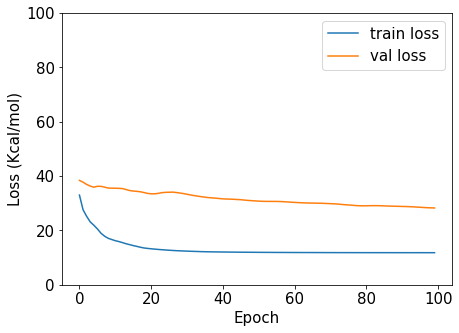

In [84]:
import matplotlib.pyplot as plt
average_dd_train_losses = [sum(x)/len(x) for x in zip(*dd_train_losses)]
average_dd_val_losses = [sum(x)/len(x) for x in zip(*dd_val_losses)]
# f, ax = plt.subplots()
plt.figure(figsize=(7,5))
plt.plot(range(len(average_dd_train_losses)), average_dd_train_losses, label='train loss')
plt.plot(range(len(average_dd_val_losses)), average_dd_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.ylim(0,100)
plt.savefig('ind_loss.png')

<h1> PGNN Model performance evaluation</h1>

In [63]:
average_pgnn_train_losses = [sum(x)/len(x) for x in zip(*pgnn_train_losses)]
average_pgnn_val_losses = [sum(x)/len(x) for x in zip(*pgnn_val_losses)]

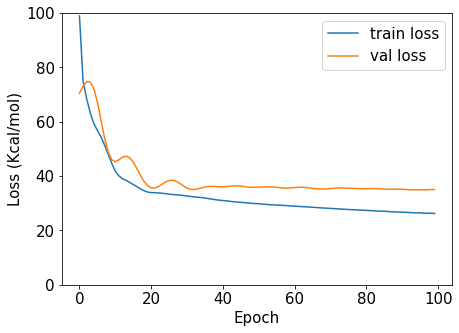

In [83]:
import matplotlib.pyplot as plt
# f, ax = plt.subplots()
plt.figure(figsize=(7,5))
plt.plot(range(len(average_pgnn_train_losses)), average_pgnn_train_losses, label='train loss')
plt.plot(range(len(average_pgnn_val_losses)), average_pgnn_val_losses, label='val loss')
plt.legend(loc='upper right');
plt.xlabel("Epoch")
plt.ylabel("Loss (Kcal/mol)")
plt.ylim(0,100)
plt.savefig('comb_loss.png')

<h1> Model variance Box Plot </h1>

In [65]:
train_results_dict = {
    "pgnn_train" : [x for x in pgnn_rmse_train],
    "dd_train" : [x for x in dd_rmse_train],
    "pgnn_validation" : [x for x in pgnn_rmse_test],
    "dd_validation" : [x for x in dd_rmse_test]
}

In [66]:
pgnn_rmse_train

[5.347233757678163, 5.380933635773864, 4.806191607493852, 4.919045643240485]

In [79]:
physics_based_rmse_train

[8.917277132820226, 9.076697417899922, 8.886531410490239, 9.569247675564485]

In [68]:
# Calculate the variance
import statistics
train_results_dict_variance = {
    "pgnn_train_variance" : [statistics.stdev(pgnn_rmse_train)],
    "dd_train_variance" : [statistics.stdev(dd_rmse_train)],
    "pgnn_validation_variance" : [statistics.stdev(pgnn_rmse_test)],
    "dd_validation_variance" : [statistics.stdev(dd_rmse_test)],
    "dd_rmse_test_variance" : [statistics.stdev(dd_rmse_test)],
    "PGNN_rmse_test_variance" : [statistics.stdev(pgnn_rmse_test)],
    "physics_rmse_test_variance" : [statistics.stdev(physics_based_rmse_test)],
    "physics_based_train_variance" : [statistics.stdev(physics_based_rmse_train)],
}
import statistics
train_results_dict_mean = {
    "pgnn_train_mean" : [statistics.mean(pgnn_rmse_train)],
    "dd_train_mean" : [statistics.mean(dd_rmse_train)],
    "pgnn_validation_mean" : [statistics.mean(pgnn_rmse_test)],
    "dd_validation_mean" : [statistics.mean(dd_rmse_test)],
    "dd_rmse_test_mean" : [statistics.mean(dd_rmse_test)],
    "PGNN_rmse_test_mean" : [statistics.mean(pgnn_rmse_test)],
    "physics_rmse_test_mean" : [statistics.mean(physics_based_rmse_test)],
    "physics_based_train_mean" : [statistics.mean(physics_based_rmse_train)],
}

In [69]:
pgnn_rmse_train

[5.347233757678163, 5.380933635773864, 4.806191607493852, 4.919045643240485]

In [70]:
train_results_dict

{'pgnn_train': [5.347233757678163,
  5.380933635773864,
  4.806191607493852,
  4.919045643240485],
 'dd_train': [3.446420504365031,
  3.59492141871194,
  3.139248674491304,
  3.549681641178987],
 'pgnn_validation': [5.9718297233042925,
  5.306703883732268,
  5.300665385386257,
  6.953237468367084],
 'dd_validation': [4.114242861539711,
  4.182009613420117,
  7.984286134229045,
  3.859549823461632]}

In [71]:
train_results_dict_variance

{'pgnn_train_variance': [0.29348655584024935],
 'dd_train_variance': [0.20518475910887432],
 'pgnn_validation_variance': [0.7798567662969069],
 'dd_validation_variance': [1.9710706164204246],
 'dd_rmse_test_variance': [1.9710706164204246],
 'PGNN_rmse_test_variance': [0.7798567662969069],
 'physics_rmse_test_variance': [1.012108412660395],
 'physics_based_train_variance': [0.3157393546159056]}

In [72]:
train_results_dict_mean

{'pgnn_train_mean': [5.113351161046591],
 'dd_train_mean': [3.4325680596868153],
 'pgnn_validation_mean': [5.883109115197476],
 'dd_validation_mean': [5.035022108162626],
 'dd_rmse_test_mean': [5.035022108162626],
 'PGNN_rmse_test_mean': [5.883109115197476],
 'physics_rmse_test_mean': [9.074306016834313],
 'physics_based_train_mean': [9.112438409193718]}

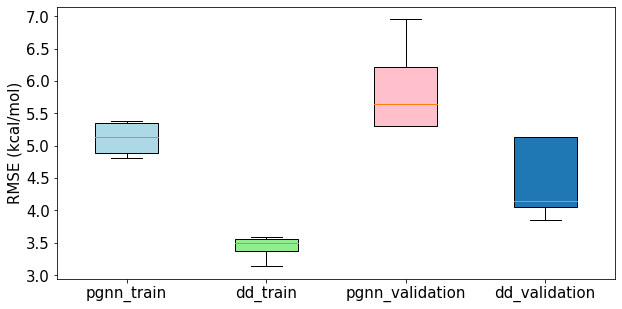

In [73]:
import matplotlib.pyplot as plt
# Train box plot
plt.figure(figsize=(10,5))
# plt.title("Train & Test RMSE varianc")
box = plt.boxplot([x for x in train_results_dict.values()],labels=[x for x in train_results_dict.keys()],
                  patch_artist=True, showfliers=False)
# plt.xlabel("PGNN and DD train")
plt.ylabel("RMSE (kcal/mol)")
# plt.xlim(3.2,  7)
plt.rc('font', size=15)

colors = ['lightblue', 'lightgreen', 'pink']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)


In [74]:
train_results_dict = {
    "pgnn_train" : [x for x in pgnn_rmse_train],
    "dd_train" : [x for x in dd_rmse_train]
#     "gbnsr6_train" : [x for x in physics_based_rmse_train]
}
test_results_dict ={
    "pgnn_test" : [x for x in pgnn_rmse_test],
    "dd_test" : [x for x in dd_rmse_test]
#     "gbnsr6_train" : [x for x in physics_based_rmse_test]
}

(3.0, 7.0)

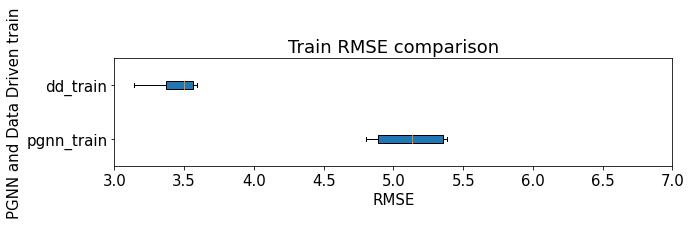

In [75]:
# Train box plot
plt.figure(figsize=(10,2))
plt.title("Train RMSE comparison")
plt.boxplot([x for x in train_results_dict.values()],labels=[x for x in train_results_dict.keys()],
            vert=False, patch_artist=True)
plt.xlabel("RMSE")
plt.ylabel("PGNN and Data Driven train")
plt.xlim(3,7)



(3.0, 7.0)

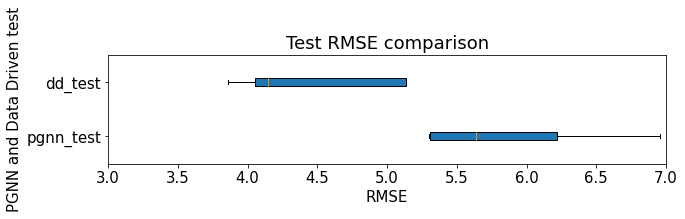

In [76]:
# Test box plot
plt.figure(figsize=(10,2))
plt.title("Test RMSE comparison")
box = plt.boxplot([x for x in test_results_dict.values()],labels=[x for x in test_results_dict.keys()],
                  vert=False, patch_artist=True)
plt.xlabel("RMSE")
plt.ylabel("PGNN and Data Driven test")

plt.xlim(3, 7)


In [77]:
dd_model.summary()

Model: "gb_graph_conv_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_conv_30 (GraphConv)    multiple                  51072     
_________________________________________________________________
batch_normalization_45 (Batc multiple                  128       
_________________________________________________________________
graph_pool_30 (GraphPool)    multiple                  0         
_________________________________________________________________
graph_conv_31 (GraphConv)    multiple                  22176     
_________________________________________________________________
batch_normalization_46 (Batc multiple                  0 (unused)
_________________________________________________________________
graph_pool_31 (GraphPool)    multiple                  0         
_________________________________________________________________
dense_38 (Dense)             multiple        

In [78]:
hybrid_model.summary()

Model: "pgnn_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
graph_conv_28 (GraphConv)    multiple                  51072     
_________________________________________________________________
batch_normalization_42 (Batc multiple                  128       
_________________________________________________________________
graph_pool_28 (GraphPool)    multiple                  0         
_________________________________________________________________
graph_conv_29 (GraphConv)    multiple                  22176     
_________________________________________________________________
batch_normalization_43 (Batc multiple                  0 (unused)
_________________________________________________________________
graph_pool_29 (GraphPool)    multiple                  0         
_________________________________________________________________
dense_35 (Dense)             multiple                  2112 